In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Lab 2: Image Stitching with Homographies

In this lab, we will explore image stitching and panorama creation. You will use a homography to register two images together, and implement bilinear interpolation to help accomplish this. As part of the lab, you will also explore image enhancement strategies to improve the quality of image stitching at the seam (the join between two images) relying on your knowledge of image brightness and human perception of this. Collectively, tasks 1-5 will provide a final stitched image. In task 6, you will apply the same code written in tasks 1-5 to create a panorama image using your own photos.

* Task 1: Draw test points on the left image
* Task 2: Use a homography to find the location of these points in the right image
* Task 3: Bilinear interpolation of the right image pixels
* Task 4: Image stitching 
* Task 5: Better blending
* Task 6: Now try your own!

### Academic integrity

Every lab submission will be screened for any collusion and/or plagiarism. Breaches of academic integrity will be investigated thoroughly and may result in a zero for the assessment along with interviews with the plagiarism officers at Monash University.

### Late submissions

The default late submission university penalty will apply.

### Lab Instructions and the Use of Generative AI

You may not use any built-in opencv functions for this lab, other than those used for loading/ saving an image, extracting and matching keypoints, and
computing homographies.
* You may use NumPy for array handling, and vectorizing your code (reducing
the number of for-loops) is encouraged.
* You should use Matplotlib to display images and any intermediate results.
* You may use generative AI.

### Grading
Each lab is worth 8%, and there are a number of sections and tasks with their own weighting. A task is only considered complete if you can demonstrate a working program and show an understanding of the underlying concepts. Note that later tasks should reuse code from earlier tasks.

Masks will be provided based on the correctness of the code, the quality of your results, comments indicating you understand your work, and a discussion of tasks provided at the end of the notebook. 

# Task 1: Draw test points on the left image

Draw the following points on the left image as red crosses. Display the resulting image.

{446 , 499, 1}, {383, 590, 1}, {296 , 499, 1}, {282, 511, 1}, {401 , 508, 1}

Recall from lectures that these 3-element homogeneous coordinates can be transformed to 2D image pixel coordinates by dividing the first and second elements by the third (needed for later tasks).

In [2]:
leftImg = cv2.imread('left.jpg')
points = [(446, 499), (383, 590), (296, 499), (282, 511), (401, 508)]

for point in points:
    cv2.drawMarker(leftImg, point, (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)

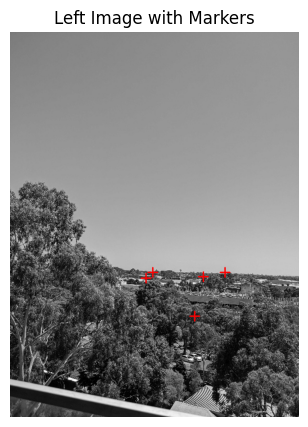

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(leftImg)
ax.set_title("Left Image with Markers")
ax.axis("off")
plt.show()

# Task 2: Use Homography to find right image points


The following homography transforms pixel coordinates between the left and right images as
$$ x_R = H x_L $$

\begin{bmatrix}
1.6011 & 0.0277 & -393.5701 \\
0.3242 & 1.5119 & -228.8918 \\
0.0009 & 0.0002 & 1.0000
\end{bmatrix}

Apply the homography to transform the left image points in Task 1 to their corresponding locations in the right image. Draw the transformed points as red crosses on the right image. Check your result before moving on.


In [4]:
H = np.array([
    [1.6011, 0.0277, -393.5701],
    [0.3242, 1.5119, -228.8918],
    [0.0009, 0.0002, 1.0000]
])
lpoints = np.array([
    [446, 499, 1],
    [383, 590, 1],
    [296, 499, 1],
    [282, 511, 1],
    [401, 508, 1]
]).T

rpoints_homogeneous = H @ lpoints
rpoints = (rpoints_homogeneous[:2] / rpoints_homogeneous[2]).T

rightImg = cv2.imread('right.jpg')
for point in rpoints:
    cv2.drawMarker(rightImg, tuple(point.astype(int)), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)

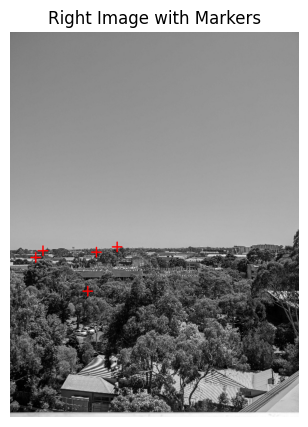

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(rightImg)
ax.set_title("Right Image with Markers")
ax.axis("off")
plt.show()

# Task 3: Bilinear interpolation of the right image

The transformed coordinates can be in between pixel locations. Write a bilinear interpolation function to compute the intensity of the transformed pixel coordinate in right.jpg using intensity values from neighbouring pixel locations. Print the interpolated intensity value for each transformed point in Task 2. The first point should be around 176 whereas the last point should be around 73.

HINT: The bilinear interpolation function should take the transformed pixel coordinate and the intensity values of its four neighbours as input arguments, and should output the interpolated intensity value.

In [6]:
def bilinear_interpolation(image, x, y):
    if len(image.shape) == 3:  # Color image (Height, Width, Channels)
        h, w, c = image.shape  
    else:  # Grayscale image (Height, Width)
        h, w = image.shape  

    # Floor and ceil values for x and y
    x1, x2 = int(np.floor(x)), int(np.ceil(x))
    y1, y2 = int(np.floor(y)), int(np.ceil(y))

    # Ensure coordinates are within image bounds
    if x1 < 0 or x2 >= w or y1 < 0 or y2 >= h:
        return 0  # Out of bounds, return black (or handle as needed)

    # For color images, handle each channel separately                          ####### Come back and remove this make them all for 3 channels remove else
    if len(image.shape) == 3:
        interpolated_values = []
        for channel in range(c):
            # Get intensity values for each channel at four neighboring pixels
            I11 = float(image[y1, x1, channel])  # Top-left
            I21 = float(image[y1, x2, channel])  # Top-right
            I12 = float(image[y2, x1, channel])  # Bottom-left
            I22 = float(image[y2, x2, channel])  # Bottom-right

            # Bilinear interpolation along x for the current channel
            I_y1 = I11 + (x - x1) * (I21 - I11)
            I_y2 = I12 + (x - x1) * (I22 - I12)

            # Bilinear interpolation along y for the current channel
            I_interp = I_y1 + (y - y1) * (I_y2 - I_y1)
            interpolated_values.append(I_interp)

        # Combine the interpolated values for each channel and return
        return np.array(interpolated_values)
    
    else:
        # Intensity values at four neighboring pixels
        I11 = float(image[y1, x1])  # Top-left
        I21 = float(image[y1, x2])  # Top-right
        I12 = float(image[y2, x1])  # Bottom-left
        I22 = float(image[y2, x2])  # Bottom-right

        # Bilinear interpolation along x
        I_y1 = I11 + (x - x1) * (I21 - I11)
        I_y2 = I12 + (x - x1) * (I22 - I12)

        # Bilinear interpolation along y
        I_interp = I_y1 + (y - y1) * (I_y2 - I_y1)

        return I_interp

In [7]:
right_gray = cv2.imread('right.jpg', cv2.IMREAD_GRAYSCALE)
# Compute and print interpolated intensity values
for point in rpoints:
    x, y = point  # Transformed floating-point coordinates
    intensity = bilinear_interpolation(right_gray, x, y)
    print(f"Interpolated intensity at ({x:.2f}, {y:.2f}): {intensity:.2f}")

Interpolated intensity at (222.72, 446.40): 176.00
Interpolated intensity at (161.34, 538.25): 38.47
Interpolated intensity at (68.93, 454.92): 69.83
Interpolated intensity at (53.17, 468.37): 58.19
Interpolated intensity at (179.52, 457.54): 74.51


# Task 4: Image stitching

Create a 1200x800 (width x height) image and fill the left hand side of this image with the left image. This stitched image will use the left image coordinate system (xl) throughout the stitching process. Next, fill in the remaining pixels on the RHS by transforming their pixel coordinates (left image coordinates) to the right image coordinates via the homography from Task 2 and determining the intensity using your bilinear interpolation implementation. If the right pixel  coordinate is valid, generate the pixel value using bilinear interpolation, but if the right pixel coordinate is invalid, use a pixel value of zero. Display the stitching results. It should look like a wide-angle image with a visible seam where the two images join.

In [8]:
def stitch_images(left_image, right_image, homography_matrix, canvas_width, canvas_height):
    # Create an empty canvas (black background)
    stitched_image = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    # Fill in the left image directly on the canvas
    stitched_image[:left_image.shape[0], :left_image.shape[1]] = left_image

    # Iterate through the right side of the canvas and apply homography to get the pixel from the right image
    for y in range(left_image.shape[0]):
        for x in range(left_image.shape[1], canvas_width):  # Start after the left image region
            # Apply the homography transformation
            point_left = np.array([x, y, 1])  # Left image coordinates (homogeneous)
            point_right = homography_matrix @ point_left  # Homography transformation
            point_right /= point_right[2]  # Convert back from homogeneous to 2D coordinates
            x_r, y_r = point_right[0], point_right[1]

            # Get the pixel intensity using bilinear interpolation
            if 0 <= x_r < right_image.shape[1] and 0 <= y_r < right_image.shape[0]:
                intensity = bilinear_interpolation(right_image, x_r, y_r)
                stitched_image[y, x] = intensity  # Assign the intensity to the stitched image

    return stitched_image

# Create the stitched image
canvas_width = 1200
canvas_height = 800
stitched_image = stitch_images(leftImg, rightImg, H, canvas_width, canvas_height)


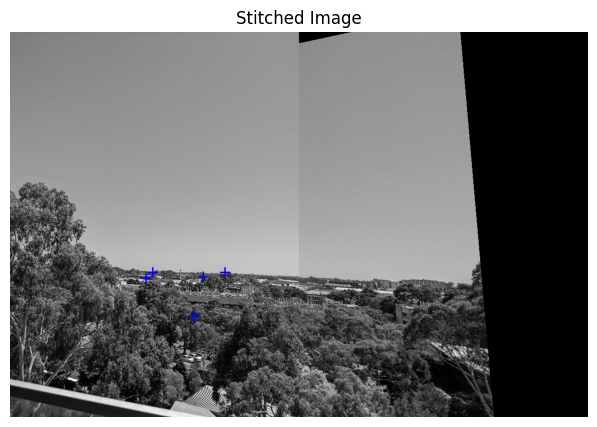

In [9]:
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')
plt.axis('off')
plt.show()

# Task 5: Better blending

Improve the visual quality of the stitched image by trying the following image processing techniques:

1. Adjust the width of the output image automatically so that fewer black pixels are
visible 
2. Adjust the brightness (by a scaling factor) of each image so that the seam is less
visible
3. Apply a small amount of Gaussian blur or alpha blending near the seam to make
it less visible
4. Adjust the horizontal location of the seam (it can be moved further to the left as
the right image overlaps into the left by quite a few pixels)

Note that you do not have to try all of the above. However, you will only receive a mark here depending on
• the quality of the stitched image
• whether a serious programming attempt is made to improve the visual quality of the stitched image

In [10]:
def adjust_brightness(image1, image2, overlap_width):
    # Convert to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Get overlap strips
    strip1 = gray1[:, -overlap_width:]  # right edge of image1
    strip2 = gray2[:, :overlap_width]   # left edge of image2

    # Compute brightness scale factor using overlap
    avg_brightness1 = np.mean(strip1)
    avg_brightness2 = np.mean(strip2)
    scale_factor = avg_brightness1 / (avg_brightness2 + 1e-5)  # prevent division by 0

    # Apply scale factor to image2
    adjusted_image2 = np.clip(image2 * scale_factor, 0, 255).astype(np.uint8)

    return image1, adjusted_image2

def crop_black_borders(image, seam_threshold):
    # Convert the image to grayscale to identify black regions
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find non-zero (non-black) pixels
    non_black_pixels = np.where(gray > 0)

    # Get the bounding box of the non-black regions
    top = min(non_black_pixels[0])
    bottom = max(non_black_pixels[0])
    left = min(non_black_pixels[1])
    right = max(non_black_pixels[1])
    
    cropped_image = image[top:bottom, left:right]

    seam_top = max(seam_threshold, 0)  # Adjust top margin
    seam_bottom = min(bottom, image.shape[0])  # Adjust bottom margin

    # Crop the image using the bounding box
    cropped_image = image[seam_top:seam_bottom, left:right]

    return cropped_image


def apply_seam_blur(stitched_image, seam_start, seam_width):
    seam_end = seam_start + seam_width
    seam_region = stitched_image[:, seam_start:seam_end]

    blur_kernel_size = 51#101
    blurred = cv2.GaussianBlur(seam_region, (blur_kernel_size, blur_kernel_size), 0)

    fade_mask = np.linspace(0, 1, seam_region.shape[1]).reshape(1, -1)
    fade_mask = np.repeat(fade_mask, seam_region.shape[0], axis=0)
    fade_mask = np.expand_dims(fade_mask, axis=-1) 
    fade_mask = np.repeat(fade_mask, 3, axis=-1)

    blended = seam_region * (1 - fade_mask) + blurred * fade_mask
    stitched_image[:, seam_start:seam_end] = blended.astype(np.uint8)

    return stitched_image

# Set up variables and reload the images
output_width = 1200
output_height = 800
seam_threshold = 35
seam_offset = 3

leftImg = cv2.imread('left.jpg')
rightImg = cv2.imread('right.jpg')

# Adjust brightness of the second image to match the first
adjusted_left, adjusted_right = adjust_brightness(leftImg, rightImg, 400)
# Stitch the images together
stitched_image = stitch_images(adjusted_left, adjusted_right, H, canvas_width, canvas_height)
# Crop the image down to reduce the black
cropped = crop_black_borders(stitched_image, seam_threshold)
# Blur the seam to make it look better
final_img = apply_seam_blur(cropped, adjusted_left.shape[1] - seam_offset, seam_width=2 * seam_offset)

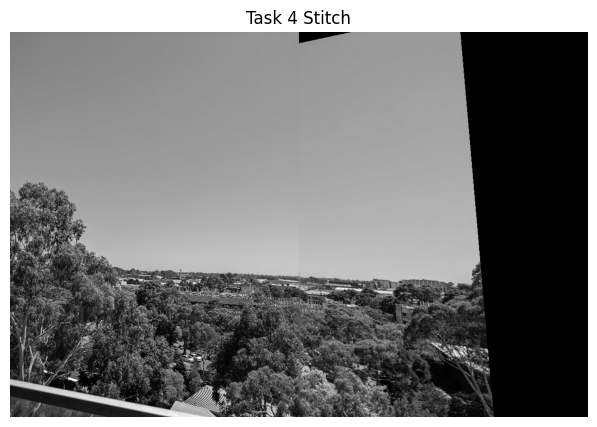

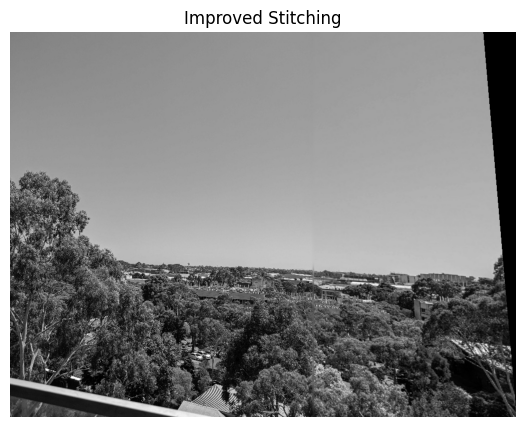

In [11]:
# Show results here
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.title('Task 4 Stitch')
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.title("Improved Stitching")
plt.axis('off')
plt.show()



# Task 6: Now try your own!

In this final task, you will:
1. Take two images from different perspective of the same scenery and display it
2. Find and match key points across the two images
3. Calculate the homography matrix1 . Print out the homography matrix that you end
up using.
4. Apply image stitching and quality improvement for a final image (from tasks 1 to 5)

Matrix from ORB:
 [[-4.02647322e+00 -2.79117835e-01  8.53350331e+03]
 [-3.00599248e+00 -3.20869353e+00  7.79891301e+03]
 [-1.59879720e-03 -8.46396187e-05  1.00000000e+00]]
Matrix from SIFT:
 [[-3.80334060e+00 -2.55502947e-01  8.04970820e+03]
 [-2.89781992e+00 -2.96963335e+00  7.39880187e+03]
 [-1.53237867e-03 -7.22812684e-05  1.00000000e+00]]
Matrix from ORB:
 [[ 5.35428458e+00 -7.26230973e-02 -1.03041401e+04]
 [ 2.27350678e+00  5.95804400e+00 -9.22608062e+03]
 [ 1.05154667e-03  4.61522394e-04  1.00000000e+00]]
Matrix from SIFT:
 [[ 3.26833241e+00  3.76975306e-02 -6.52927930e+03]
 [ 1.41608115e+00  3.06141050e+00 -4.44979351e+03]
 [ 6.52273640e-04  8.44014834e-05  1.00000000e+00]]


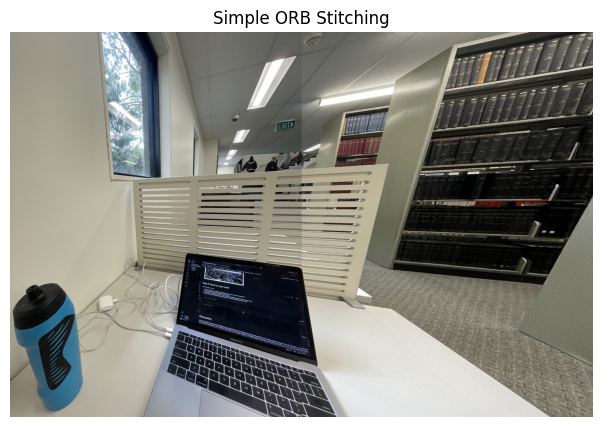

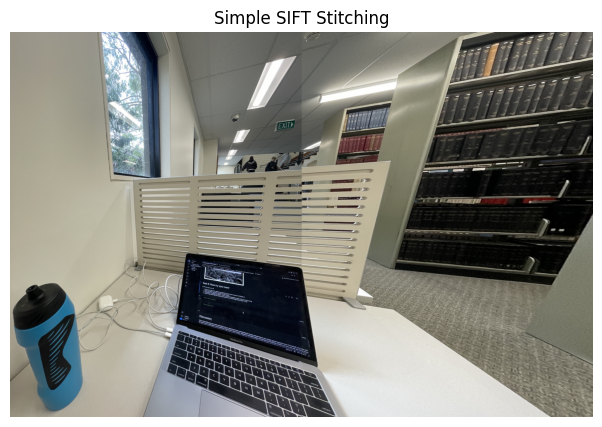

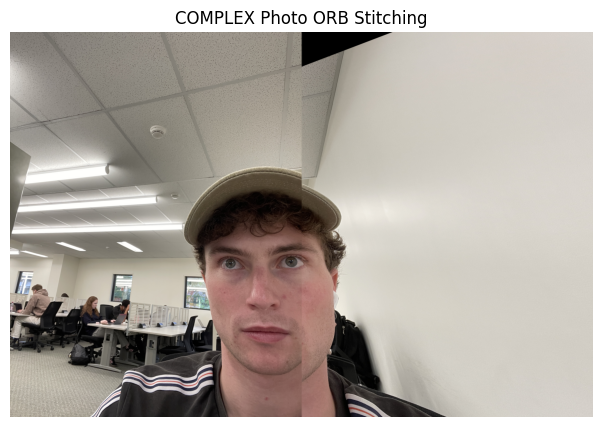

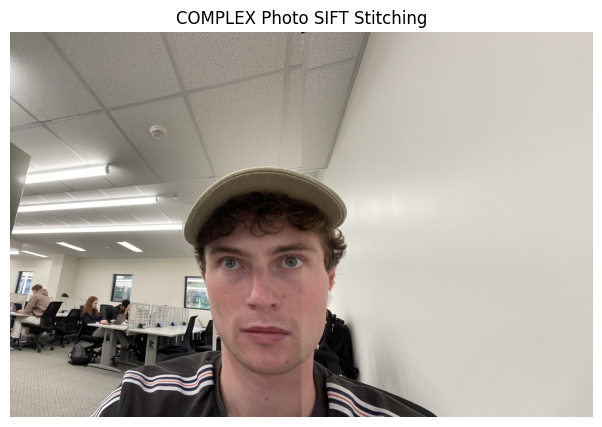

In [14]:
def stitching_function(leftImg_grey, rightImg_grey):
    ##############################################################################################################################
    ##############################################################################################################################
    # Initiate ORB detector
    orb = cv2.ORB_create()
    # Find the keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(leftImg_grey,None)
    kp2, des2 = orb.detectAndCompute(rightImg_grey,None)
    # Match keypoints
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    # Sort matches
    matches = sorted(matches, key = lambda x:x.distance)
    # Find keypoint correspondences
    X1 = np.vstack([kp1[match.queryIdx].pt for match in matches])
    X2 = np.vstack([kp2[match.trainIdx].pt for match in matches])
    ##############################################################################################################################
    ##############################################################################################################################
    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # Find the keypoints and descriptors
    kp1S, des1S = sift.detectAndCompute(leftImg_grey, None)
    kp2S, des2S = sift.detectAndCompute(rightImg_grey, None)
    # Match keypoints using FLANN for better performance with float descriptors
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1S, des2S, k=2)
    # Lowe's ratio test
    good_matches_SIFT = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches_SIFT.append(m)

    X1S = np.vstack([kp1S[m.queryIdx].pt for m in good_matches_SIFT])
    X2S = np.vstack([kp2S[m.trainIdx].pt for m in good_matches_SIFT])
    ##############################################################################################################################
    ##############################################################################################################################

    # Create a matrix from 1 keypoint correspondence
    def point_correspondance_matrix(x,y,u,v):
        
        row_1 = np.array([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        row_2 = np.array([0, 0, 0, -x, -y, -1, x*v, y*v, v])

        return (np.vstack([row_1,row_2]))
        
    # Create a full matrix from multiple keypoint correspondences - technically this works with more than 4 points too
    def four_point_correspondance_matrix(kp1,kp2):
        
        rows = []
        for i in range(kp1.shape[0]):
            rows.append(point_correspondance_matrix(kp1[i,0],kp1[i,1],kp2[i,0],kp2[i,1]))
        return np.vstack(rows)
    # Find the homography using singular value decomposition
    def find_homography(kp1,kp2):
        
        M = four_point_correspondance_matrix(kp1,kp2)
        
        U,S,Vt  = np.linalg.svd(M)
        H = Vt[-1,:].reshape(3,3) #Null space corresponds to smallest singular value
        return H/H[2,2] # Typically normalise by the last element of the homography 

    # Find the homography using singular value decomposition
    def find_homography(kp1,kp2):
        
        M = four_point_correspondance_matrix(kp1,kp2)
        
        U,S,Vt  = np.linalg.svd(M)
        H = Vt[-1,:].reshape(3,3) #Null space corresponds to smallest singular value
        return H/H[2,2] # Typically normalise by the last element of the homography 
    # Find a homography using ransac
    def ransac_homography(kp1,kp2,N=1000,max_error=5.0):
        
        best_consensus_size = 0
        best_H = np.eye(3)
        
        for j in range(N):
            
            # Pick 4 points at random
            bins = np.random.choice(kp1.shape[0],4,replace=False)
            
            # Calculate Homography
            H = find_homography(kp1[bins,:],kp2[bins,:])
            
            # Project points using Homography
            X1_h = np.hstack((kp1,np.ones((kp1.shape[0],1)))).T # homogenous coordinates
            
            projected = H@X1_h
            # Normalise (last column must be one for homogenous coordinates) 
            X1_2 = projected[0:2,:]/projected[2,:] 
            
            # Calculate reprojection error
            reprojection_errors = np.sqrt(np.sum(np.power(X2-X1_2.T,2),axis=1))
            
            # Count consensus set size
            consensus_size = np.sum(reprojection_errors<max_error)
            
            # Save current best homography
            if consensus_size > best_consensus_size:
                best_consensus_size = consensus_size
                best_H = H
                
        return best_H

    def ransac_homography2(kp1,kp2,N=1000,max_error=5.0):
        
        best_consensus_size = 0
        best_H = np.eye(3)
        
        for j in range(N):
            
            # Pick 4 points at random
            bins = np.random.choice(kp1.shape[0],4,replace=False)
            
            # Calculate Homography
            H = find_homography(kp1[bins,:],kp2[bins,:])
            
            # Project points using Homography
            X1_h = np.hstack((kp1,np.ones((kp1.shape[0],1)))).T # homogenous coordinates
            
            projected = H@X1_h
            # Normalise (last column must be one for homogenous coordinates) 
            X1_2 = projected[0:2,:]/projected[2,:] 
            
            # Calculate reprojection error
            reprojection_errors = np.sqrt(np.sum(np.power(kp2 - X1_2.T, 2), axis=1))        
            # Count consensus set size
            consensus_size = np.sum(reprojection_errors<max_error)
            
            # Save current best homography
            if consensus_size > best_consensus_size:
                best_consensus_size = consensus_size
                best_H = H
                
        return best_H
    ######
    H = ransac_homography(X1,X2,N=10000,max_error=5)
    print('Matrix from ORB:\n', H)
    H_SIFT = ransac_homography2(X1S,X2S,N=10000,max_error=5)
    print('Matrix from SIFT:\n', H_SIFT)

    return H, H_SIFT

seam_threshold = 35
seam_offset = 5
# Load images
leftImg = cv2.imread('myPhotos/libLeft.JPG')
leftImg = cv2.cvtColor(leftImg, cv2.COLOR_BGR2RGB)
rightImg = cv2.imread('myPhotos/libRight.JPG')
rightImg = cv2.cvtColor(rightImg, cv2.COLOR_BGR2RGB) 

# Grey version of the images
leftImg_grey = leftImg.copy()
leftImg_grey = cv2.cvtColor(leftImg, cv2.COLOR_BGR2GRAY)
rightImg_grey = rightImg.copy()
rightImg_grey = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)

H, H_SIFT = stitching_function(leftImg_grey, rightImg_grey)

# Dynamically set the canvas size
canvas_height = max(leftImg.shape[0], rightImg.shape[0])
canvas_width = leftImg.shape[1] + rightImg.shape[1]

######
stitched_image = stitch_images(leftImg, rightImg, H, canvas_width, canvas_height)
cropped = crop_black_borders(stitched_image, seam_threshold)
final_img = apply_seam_blur(cropped, leftImg.shape[1] - seam_offset, seam_width=2 * seam_offset)
print('ORB Image 1: Done')
plt.figure(figsize=(10, 5))
plt.imshow(final_img, cmap="gray")
plt.title("Simple ORB Stitching")
plt.axis('off')

######
SIFTstitched_image = stitch_images(leftImg, rightImg, H_SIFT, canvas_width, canvas_height)
SIFTcropped = crop_black_borders(SIFTstitched_image, seam_threshold)
SIFTimg = apply_seam_blur(SIFTcropped, leftImg.shape[1] - seam_offset, seam_width=2 * seam_offset)
print('SIFT Image 1: Done')
plt.figure(figsize=(10, 5))
plt.imshow(SIFTimg)
plt.title("Simple SIFT Stitching")
plt.axis('off')

# Load images for another image
leftImg = cv2.imread('myPhotos/meLeft.JPG')
leftImg = cv2.cvtColor(leftImg, cv2.COLOR_BGR2RGB)
rightImg = cv2.imread('myPhotos/meRight.JPG')
rightImg = cv2.cvtColor(rightImg, cv2.COLOR_BGR2RGB) 

# Grey version of the images
leftImg_grey = leftImg.copy()
leftImg_grey = cv2.cvtColor(leftImg, cv2.COLOR_BGR2GRAY)
rightImg_grey = rightImg.copy()
rightImg_grey = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)

H, H_SIFT = stitching_function(leftImg_grey, rightImg_grey)

######
stitched_image2 = stitch_images(leftImg, rightImg, H, canvas_width, canvas_height)
cropped2 = crop_black_borders(stitched_image2, seam_threshold)
final_img2 = apply_seam_blur(cropped2, leftImg.shape[1] - seam_offset, seam_width=2 * seam_offset)
print('ORB Image 2: Done')
plt.figure(figsize=(10, 5))
plt.imshow(final_img2, cmap="gray")
plt.title("COMPLEX Photo ORB Stitching")
plt.axis('off')

######
SIFTstitched_image2 = stitch_images(leftImg, rightImg, H_SIFT, canvas_width, canvas_height)
SIFTcropped2 = crop_black_borders(SIFTstitched_image2, seam_threshold)
SIFTimg2 = apply_seam_blur(SIFTcropped2, leftImg.shape[1] - seam_offset, seam_width=2 * seam_offset)
print('SIFT Image 2: Done')
plt.figure(figsize=(10, 5))
plt.imshow(SIFTimg2)
plt.title("COMPLEX Photo SIFT Stitching")
plt.axis('off')
plt.show()


# Discussion:

Write a brief (600 word max) report describing how you solved each task, interpreting the results and pointing to any insights gained along the way. For example, you may wish to explain what a homography is, the conditions under which it can be used. Analyse the stitched images and explain any interesting artifacts you may see and why these occur. You should discuss the reasons for the presence of the image seam, and the strategies you used to improve this, pointing to the theory you have learned in class that guided your solution. Finally, explain any changes you made to the code to apply it to your own images. 



This lab was split into two stages. The first task involved stitching two images together using a given homography matrix; the second required me to stitch two of my own images using a homography matrix that I had to compute myself.

A homography matrix is a 3×3 transformation matrix that defines a projective transformation between two planes. It maps corresponding points between images that share the same center of projection, typically when a camera rotates without translating. This makes it ideal for panoramic stitching or overlays in live sports broadcasts.

Task 1:
I began by using the given homography matrix to warp points from the left image into the coordinate space of the right image. 
The matrix allowed me to align the two images. However, once stitched, a visible seam appeared due to subtle lighting differences, slight parallax errors, and small inaccuracies in the homography itself. To improve the visual result, I applied several post-processing techniques:
Cropping to remove black borders caused by warping.
Brightness and contrast adjustment to reduce the visible intensity differences between the two images.
Blurring the seam using a Gaussian filter to smooth transitions.
I found Gaussian blur worked best in regions with low detail but became noticeable in higher detailed areas like trees. To handle this, I increased the blur strength but reduced it to a narrow region around the seam, minimising detail loss. I also found that adjusting brightness near the seam specifically, rather than averaging across the whole image, significantly improved blending. This approach better matched local luminance and reduced visible edges between images.

Task 2: Estimating a Homography Using Feature Matching
This task involved computing the homography manually through feature detection and matching. I used ORB (Oriented FAST and Rotated BRIEF) and SIFT (Scale-Invariant Feature Transform) from OpenCV due to its efficiency and I understood it since we had covered it in our workshops. ORB detects key points, often corners, by finding areas with strong gradient changes. These are then matched between images using a similarity metric on the feature descriptors. SIFT, on the other hand, detects distinctive, scale- and rotation-invariant key points and generates rich, floating-point descriptors that are more robust to changes in lighting and scale. I used both methods to compare their results, and in my case, they performed similarly.
With the matched pairs, I estimated the homography using a RANSAC-based algorithm. RANSAC filters out incorrect matches by iteratively fitting models and selecting the one with the most inliers. This produces a robust homography matrix even in the presence of mismatches.
I reused the warping and stitching function from Task 1, then applied the same post-processing: cropping, brightness adjustments, and Gaussian blur. These steps helped improve the appearance of the final stitched image.

Analysis of Stitched Results
After stitching, I noticed a few key things:
Seams were still occasionally visible, usually due to exposure or perspective differences. Gaussian blur helped but didn’t always remove them completely.
Ghosting is caused by object movement between images (e.g., trees or people), leading to semi-transparent duplicates.
Black borders appeared outside the overlap area due to the warp. These were cropped out.
These issues highlight how critical consistent lighting, scale, and camera position are. In Task 2, since I took the images consecutively from the same spot, the seam wasn't as obvious, and alignment was easier. However, I found ORB to be somewhat inconsistent resulting in the stitched image being misaligned. 

For more complex scenes, like the close-up of my face, SIFT performed significantly better. The detailed and curved features in facial images demand high descriptor accuracy, and SIFT handled these with much greater reliability than ORB. Ghosting was also more apparent in these cases, and the complexity of human features made flaws stand out clearly. Even using an iPhone in panorama mode struggled with stitching facial features properly, highlighting how challenging such content is to process. Simpler scenes were much easier to stitch, but using a complex image like a face helped reveal the strengths and limitations of the different feature detection methods.